In [55]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import sys
import time
# plt.style.use('dark_background')

In [56]:
# print(torch.cuda.is_available())
#
# print(torch.cuda.device_count())

In [57]:
# download training data from domain

training_data = datasets.FashionMNIST(
    root='data/',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='data/',
    train=False,
    download=True,
    transform=ToTensor(),
)

In [58]:
batch_size= 64

# create data loaders; used to make our datasets iterable of batch size
train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, batch_size)

for X, y in test_dataloader:
    print('Shape of X [N, C, H, W]:', X.shape)
    print('shape of y: ', y.shape, y.dtype)
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
shape of y:  torch.Size([64]) torch.int64


In [59]:
training_data.classes


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [60]:
len(training_data), len(test_data)

(60000, 10000)

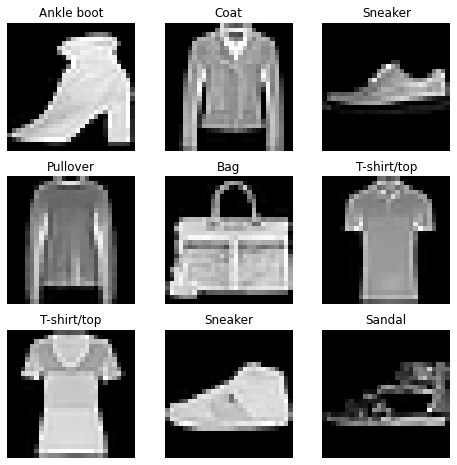

In [61]:
labels_map = training_data.classes

figure = plt.figure(figsize=(8,8))
cols, rows = 3,3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    # used to show entire batch sample of images
    figure.add_subplot(rows, cols, i)
    # this is just for aesthetics
    plt.title(labels_map[label])
    plt.axis("off")
    # this shows the image
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [62]:
print(sys.getrecursionlimit())
sys.setrecursionlimit(100000)
print(sys.getrecursionlimit())

100000
100000


In [63]:
# creat models
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
# print("Using {} device".format(device))
# define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [64]:
# optmization and loss fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [65]:
# make functions for running nn on our train and test
# in the loop, teh model makes predictions from the training data (and each iteration will
# be a batch of data), after predictions we backpropagate the prediction erros to adjust
# the parameters

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # computer pred error
        pred = model(X)
        loss = loss_fn(pred, y)

        # bp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [66]:
# can also check the models performacne against the dataset to ensure it is learning
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= size
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [71]:
start = time.time()
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
end = time.time()
duration = round(end - start, 2)
print("Done! Duration:", duration, 'seconds')

Epoch 1
-------------------------------
loss: 0.253779 [    0/60000]
loss: 0.435515 [ 6400/60000]
loss: 0.267931 [12800/60000]
loss: 0.473817 [19200/60000]
loss: 0.358384 [25600/60000]
loss: 0.398439 [32000/60000]
loss: 0.402119 [38400/60000]
loss: 0.562229 [44800/60000]
loss: 0.541890 [51200/60000]
loss: 0.377536 [57600/60000]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.006840 

Epoch 2
-------------------------------
loss: 0.252844 [    0/60000]
loss: 0.434261 [ 6400/60000]
loss: 0.267366 [12800/60000]
loss: 0.472472 [19200/60000]
loss: 0.357274 [25600/60000]
loss: 0.397299 [32000/60000]
loss: 0.400904 [38400/60000]
loss: 0.561010 [44800/60000]
loss: 0.540371 [51200/60000]
loss: 0.376795 [57600/60000]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.006827 

Epoch 3
-------------------------------
loss: 0.251914 [    0/60000]
loss: 0.433012 [ 6400/60000]
loss: 0.266777 [12800/60000]
loss: 0.471195 [19200/60000]
loss: 0.356174 [25600/60000]
loss: 0.396190 [32000/60000]
loss: 0.399748 [38400/

In [68]:
# save model

# torch.save(model.state_dict(), 'models/tutorial_model')

In [69]:
# loading models

# tmp = NeuralNetwork()
# tmp.load_state_dict(torch.load('models/tutorial_model'))

In [70]:
classes = [
    "T-shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
